<a href="https://colab.research.google.com/github/yohanesnuwara/pyreservoir/blob/master/notebooks/oil_reservoir_drive_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
!git clone https://github.com/yohanesnuwara/pyreservoir

Cloning into 'pyreservoir'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 350 (delta 62), reused 0 (delta 0), pack-reused 234
Receiving objects: 100% (350/350), 351.39 KiB | 7.48 MiB/s, done.
Resolving deltas: 100% (184/184), done.


## Volatile Saturated Oil Reservoir (Rv > 0)

Prudhoe Bay field, North Slope, Alaska

In [ ]:
def calculate_aquifer(F, Eg, Eo, Efw, Bg, Bo, Nfoi, Gfgi):
  Boi, Bgi = Bo[0], Bg[0]
  We_schilthuis = (Bw * Wp) + F - (Nfoi * Eo) - (Gfgi * Eg) - (((Nfoi * Boi) + (Gfgi * Bgi)) * Efw)
  return We_schilthuis

def expansion_factor(p, Bg, Bo, Rs, Rv, cf, cw, swi):
  pi, Boi, Bgi, Rsi, Rvi = p[0], Bo[0], Bg[0], Rs[0], Rv[0]

  # Formation expansion factor
  Efw = ((cf + cw * swi) / (1 - swi)) * (pi - p)
  # Oil expansion factor
  Bto = ((Bo * (1 - (Rv * Rsi))) + (Bg * (Rsi - Rs))) / (1 - (Rv * Rs))  # in RB/scf
  Eo = Bto - Boi
  # Gas expansion factor
  Btg = ((Bg * (1 - (Rs * Rvi))) + (Bo * (Rvi - Rv))) / (1 - (Rv * Rs))  # in RB/STB
  Eg = Btg - Bgi

  return Efw, Eo, Eg

def oil_reservoir_voidage(Bg, Bo, Np, net_gas_flux, Rs, Rv):
  # gas net flux = gas production - gas injection = Gp - Gi
  F = (Np * ((Bo - (Rs * Bg)) / (1 - (Rv * Rs)))) + (net_gas_flux * ((Bg - (Rv * Bo)) / (1 - (Rv * Rs))))
  return F

def oil_drive_indice(F, Efw, Nfoi, Gfgi, Eo, Eg, Bo, Bg, We, Bw, Wp, Wi):
  import numpy as np

  Boi, Bgi = Bo[0], Bg[0]

  # Depletion Drive Indice
  Idd = (Nfoi * Eo) / F 
  # Segregation Drive Indice
  Isd = (Gfgi * Eg) / F 
  # Formation Drive Indice
  Ifd = (((Nfoi * Boi) + (Gfgi * Bgi)) * Efw) / F 
  # Water Drive Indice
  deltaW = We + (Bw * (Wi - Wp)) 
  Iwd = deltaW / F

  return Idd, Isd, Ifd, Iwd

In [ ]:
columns = ['p', 'Np', 'net gas flux', 'Wp', 'Wi', 'Bg', 'Bo', 'Rs', 'Rv', 'We']
df = pd.read_csv('/content/pyreservoir/data/volatile_sat_oil_proddata.csv', names=columns)
df

,p,Np,net gas flux,Wp,Wi,Bg,Bo,Rs,Rv,We
0,4320,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.830,1.3647,710.0,23.9,NaN
1,4225,8.000000e+08,1.300000e+08,1.800000e+06,0.000000e+00,0.845,1.3578,693.5,23.0,1.092310e+11
2,4130,1.650000e+09,2.690000e+08,9.200000e+06,0.000000e+00,0.860,1.3509,677.0,22.0,1.087110e+11
3,4030,2.380000e+09,4.260000e+08,1.900000e+07,0.000000e+00,0.875,1.3440,660.0,21.0,1.005090e+11
4,3930,3.110000e+09,6.120000e+08,3.210000e+07,1.020000e+07,0.890,1.3370,643.0,20.0,9.602490e+10
5,3830,4.420000e+09,9.810000e+08,1.670000e+08,6.920000e+08,0.910,1.3301,626.0,19.1,9.246380e+10
6,3730,6.500000e+09,1.760000e+09,1.060000e+09,2.470000e+09,0.930,1.3232,609.0,18.2,1.013560e+11
7,3630,7.490000e+09,2.380000e+09,1.820000e+09,3.480000e+09,0.950,1.3164,592.5,17.3,1.015280e+11
8,3530,8.270000e+09,3.080000e+09,2.710000e+09,4.650000e+09,0.970,1.3095,576.0,16.4,9.959950e+10


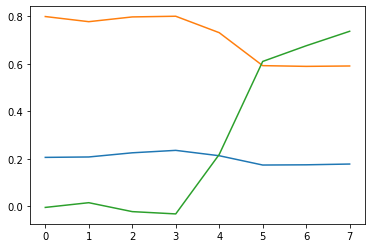

In [ ]:
# ignore warning caused by division with zero
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# known
cf = 0 # Formation compressibility, not known
cw = 0 # Water compressibility, not known
swi = 0 # Initial water saturation, not known

Nfoi = 22.460 * 1E+9 # OOIP, convert to STB
Gfgi = 37.344 * 1E+12 # OGIP, convert to SCF 

# define input variables
p = df['p'].values # Pressure, psia
Bg = df['Bg'].values * (1 / 1E+3) # Gas FVF, convert to RB/SCF
Bo = df['Bo'].values # Oil FVF, convert to RB/STB
Np = df['Np'].values # Oil production, STB
net_gas_flux = df['net gas flux'].values * 1E+3 # Net gas influx, convert to SCF
Rs = df['Rs'].values # Solution gas-oil ratio, SCF/STB
Rv = df['Rv'].values * (1 / 1E+6) # Volatile oil-gas ratio, STB/MMSCF

Wp = df['Wp'].values # Water production, STB
Wi = df['Wi'].values # Water injection, STB
# We = df['We'].values # Water influx, STB
Bw = np.full(len(df), 1)

# calculate reservoir voidage
F = oil_reservoir_voidage(Bg, Bo, Np, net_gas_flux, Rs, Rv)

# calculate expansion factors
Efw, Eo, Eg = expansion_factor(p, Bg, Bo, Rs, Rv, cf, cw, swi)

# calculate Schilthuis aquifer influx
We = calculate_aquifer(F, Eg, Eo, Efw, Bg, Bo, Nfoi, Gfgi)

# calculate drive indices
Idd, Isd, Ifd, Iwd = oil_drive_indice(F, Efw, Nfoi, Gfgi, Eo, Eg, Bo, Bg, We, Bw, Wp, Wi)

Idd, Isd, Iwd = Idd[1:], Isd[1:], Iwd[1:]

plt.plot(np.arange(len(Idd)), Idd)
plt.plot(np.arange(len(Isd)), Isd)
plt.plot(np.arange(len(Iwd)), Iwd)
plt.show()

In [ ]:
Iwd

array([-0.00416715,  0.01571219, -0.02180935, -0.03145135,  0.21836746,
        0.60932783,  0.6751836 ,  0.73608916])

In [ ]:
Iwd = np.array([np.nan, -0.00245, -0.00608, -0.00857, -0.00744, 0.12280, 0.21487, 0.20935, 0.21021])
deltaW = Iwd * F
We = deltaW - Bw * (Wi - Wp)
We

array([            nan, -6.20025822e+02, -6.45862750e+03,  1.13973104e+04,
       -7.01736815e+03,  5.97277638e+05,  5.30941656e+06,  5.65422448e+05,
       -2.39413633e+06])

## Conroe Field

### Part 1. Processing Production and PVT Data

In [ ]:
columns = ['date', 'p', 'Np', 'Wp', 'Wi', 'Wp-Wi', 'Gp']
df = pd.read_csv('/content/pyreservoir/data/conroe_proddata.csv', names=columns)

df.head(10)

,date,p,Np,Wp,Wi,Wp-Wi,Gp
0,1 January 1932,2180.0,0.0,0.0,0.0,0.0,0.0
1,1 July 1932,2177.0,1341096.0,0.0,0.0,0.0,3330412.0
2,1 January 1933,2170.0,2681691.0,0.0,0.0,0.0,6412824.0
3,1 July 1933,2148.0,9784770.0,0.0,0.0,0.0,14900678.0
4,1 January 1934,2125.0,23440301.0,0.0,0.0,0.0,24295374.0
5,1 July 1934,2110.0,32325186.0,0.0,0.0,0.0,30585954.0
6,1 January 1935,2103.0,39819896.0,71470.0,0.0,71470.0,35940966.0
7,1 July 1935,2105.0,47414017.0,143243.0,0.0,143243.0,41313677.0
8,1 January 1936,2096.0,54185666.0,188180.0,0.0,188180.0,46221132.0
9,1 July 1936,2089.0,61129694.0,346001.0,0.0,346001.0,50923634.0


In [ ]:
columns = ['p', 'Bg', 'Bt']
pvt = pd.read_csv('/content/pyreservoir/data/conroe_pvtdata.csv', names=columns)

pvt.head(10)

,p,Bg,Bt
0,2180.0,1.187,1.205
1,2164.0,1.197,1.208
2,2115.0,1.226,1.218
3,2065.0,1.256,1.229
4,2015.0,1.289,1.240
5,1965.0,1.322,1.253
6,1915.0,1.358,1.266
7,1865.0,1.395,1.280
8,1815.0,1.435,1.295
9,1765.0,1.475,1.310


In [ ]:
import sys
sys.path.append('/content/pyreservoir/pvt')
from pvtlab import linear_interpolate

# define variables in PVT data
p, Bg, Bt = pvt['p'].values, pvt['Bg'].values, pvt['Bt'].values

# define variables in production data
p1 = df['p'].values

# interpolate Bg and Bt from PVT to production data
Bg_interpolated = linear_interpolate(p, p1, Bg)
Bt_interpolated = linear_interpolate(p, p1, Bt)


array([1.187     , 1.188875  , 1.19325   , 1.20646939, 1.22008163,
       1.229     , 1.2332    , 1.232     , 1.2374    , 1.2416    ,
       1.2434    , 1.2524    , 1.253     , 1.2488    , 1.2464    ,
       1.2446    , 1.2422    , 1.2422    , 1.2434    , 1.2452    ,
       1.25      , 1.2548    , 1.26062   , 1.26722   , 1.27976   ,
       1.2956    , 1.29692   , 1.30682   , 1.31474   , 1.32344   ,
       1.33136   , 1.33712   , 1.34288   , 1.35656   , 1.35584   ,
       1.35512   , 1.35008   , 1.35152   , 1.3544    , 1.36688   ,
       1.3691    ])

In [ ]:
# add the interpolated Bg and Bt data into production dataframe
df['Bg'] = Bg_interpolated
df['Bt'] = Bt_interpolated

# convert time column to datetime
df['date'] =  pd.to_datetime(df['date'], format='%d %B %Y')

df.head(10)

,date,p,Np,Wp,Wi,Wp-Wi,Gp,Bg,Bt
0,1932-01-01,2180.0,0.0,0.0,0.0,0.0,0.0,1.187000,1.205000
1,1932-07-01,2177.0,1341096.0,0.0,0.0,0.0,3330412.0,1.188875,1.205563
2,1933-01-01,2170.0,2681691.0,0.0,0.0,0.0,6412824.0,1.193250,1.206875
3,1933-07-01,2148.0,9784770.0,0.0,0.0,0.0,14900678.0,1.206469,1.211265
4,1934-01-01,2125.0,23440301.0,0.0,0.0,0.0,24295374.0,1.220082,1.215959
5,1934-07-01,2110.0,32325186.0,0.0,0.0,0.0,30585954.0,1.229000,1.219100
6,1935-01-01,2103.0,39819896.0,71470.0,0.0,71470.0,35940966.0,1.233200,1.220640
7,1935-07-01,2105.0,47414017.0,143243.0,0.0,143243.0,41313677.0,1.232000,1.220200
8,1936-01-01,2096.0,54185666.0,188180.0,0.0,188180.0,46221132.0,1.237400,1.222180
9,1936-07-01,2089.0,61129694.0,346001.0,0.0,346001.0,50923634.0,1.241600,1.223720


In [ ]:
# define input variables
t = df['date'].values
p = df['p'].values
Np = df['Np'].values
Wp = df['Wp'].values
Wi = df['Wi'].values
Gp = df['Gp'].values * 1E+3 # convert to SCF  
Bg = df['Bg'].values * (1 / 1E+3) # convert to RB/SCF
Bt = df['Bt'].values
Bw = np.full(len(df), 1) # Water FVF is made constant, 1 RB/STB


### Part 2. Calculate Aquifer Influx

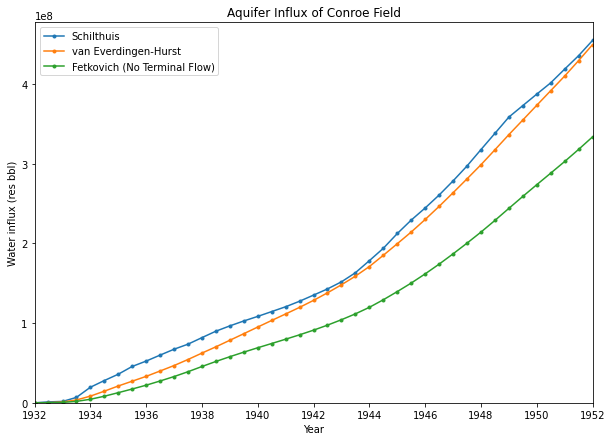

In [ ]:
# all known data of Conroe field
Nfoi = 800.44 * 1E+6 # OOIP from volumetrics, STB
Gfgi = 350 * 1E+9 # Original gas cap volume from volumetrics, SCF
Rsi = 600 # SCF/STB
Boi = 1.205 # Original oil FVF, RB/STB
Bgi = 1.187 * (1 / 1E+3) # Original gas FVF, convert to RB/SCF
Vwi = 20 * 1E+6 # Interstitial water volume, bbl
hsand = 200 # Gross sand thickness, ft
poro = 0.28
re = 6600 # Reservoir radius, ft
r_aq = 264000 # Aquifer radius, ft
k = 265 # Permeability, md
cw = 3.4E-6 # Water compressibility, sip
cf = 3.4E-6 # Formation compressibility, sip
mu_w = 0.38 # Water viscosity, cp

# calculate Swi from hsand, poro, and Vwi
Vbulk = np.pi * (re**2) * hsand # ft3
PV = poro * Vbulk # pore volume, ft3
Vwi = Vwi * 5.6145 # convert to ft3
swi = Vwi / PV

# calculate aquifer influx 
import sys
sys.path.append('/content/pyreservoir/matbal')
from aquifer import *

## Schilthuis
method = schilthuis()
We_schilthuis = We_schilthuis = schilthuis.calculate_aquifer(method, p, Bw, Wp, Np, Bt, Nfoi, cf, cw, swi, Bt[0])

## VEH
method = veh()
B_star = veh.calculate_aquifer_constant(method, re, hsand, cf, cw, poro)
We_veh = veh.calculate_aquifer(method, t, p, cf, cw, k, poro, mu_w, re, B_star)

## Fetkovich
method = fetkovich()
ct = cf + cw
theta = 360
Wei = fetkovich.initial_encroachable_water(method, p[0], ct, re, r_aq, hsand, poro, theta)
J = fetkovich.productivity_index(method, k, hsand, mu_w, r_aq, re, theta, flow='no flow')
We_fetkovich = fetkovich.calculate_aquifer(method, t, p, Wei, J)

# plot the aquifer influx
plt.figure(figsize=(10,7))
plt.plot(t, We_schilthuis, '.-', label='Schilthuis')
plt.plot(t, We_veh, '.-', label='van Everdingen-Hurst')
plt.plot(t, We_fetkovich, '.-', label='Fetkovich (No Terminal Flow)')
plt.title('Aquifer Influx of Conroe Field')
plt.xlabel('Year')
plt.ylabel('Water influx (res bbl)')
plt.xlim(min(t), max(t)); plt.ylim(ymin=0)

plt.legend()
plt.show()


In [ ]:
# for non-volatile saturated oil reservoir
# known data is not Bo, but Bt (total oil FVF)
def expansion_factor(p, Bg, Bto, cf, cw, swi):
  pi, Boi, Bgi = p[0], Bto[0], Bg[0]

  # Formation expansion factor
  Efw = ((cf + cw * swi) / (1 - swi)) * (pi - p)
  # Oil expansion factor
  Eo = Bto - Boi
  # Gas expansion factor
  Btg = Bg  # in RB/STB
  Eg = Btg - Bgi

  return Efw, Eo, Eg

def oil_reservoir_voidage(Bg, Bto, Np, Gp, Rsi):
  F = (Np * (Bto - (Rsi * Bg))) + (Gp * Bg)
  return F

def oil_drive_indice(F, Efw, Eo, Eg, Nfoi, Gfgi, Boi, Bgi, We, Bw, Wp, Wi):
  import numpy as np

  # Depletion Drive Index
  Idd = (Nfoi * Eo) / F 
  # Segregation Drive Index
  Isd = (Gfgi * Eg) / F 
  # Formation Drive Index
  Ifd = (((Nfoi * Boi) + (Gfgi * Bgi)) * Efw) / F 
  # Water Drive Index
  deltaW = We + (Bw * (Wi - Wp)) 
  Iwd = deltaW / F
  
  return Idd, Isd, Ifd, Iwd

def oil_drive_indice(F, Efw, Eo, Eg, Nfoi, Gfgi, Boi, Bgi, We, Bw, Wp, Wi):
  import numpy as np

  # Depletion Drive Index
  Idd = (Nfoi * Eo) / F 
  # Segregation Drive Index
  Isd = (Gfgi * Eg) / F 
  # Formation Drive Index
  Ifd = (((Nfoi * Boi) + (Gfgi * Bgi)) * Efw) / F 
  # Water Drive Index
  deltaW = We - (Bw * Wp)
  Iwd = deltaW / F
  # Water Injection Index
  Iwi = Wi * Bw / F

  return Idd, Isd, Ifd, Iwd, Iwi

In [ ]:
# calculate reservoir voidage
F = oil_reservoir_voidage(Bg, Bt, Np, Gp, Rsi)

# calculate expansion factors
Efw, Eo, Eg = expansion_factor(p, Bg, Bt, cf, cw, swi)

# calculate drive indices
Idd, Isd, Ifd, Iwd, Iwi = oil_drive_indice(F, Efw, Eo, Eg, Nfoi, Gfgi, Boi, Bgi, We_schilthuis, Bw, Wp, Wi)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


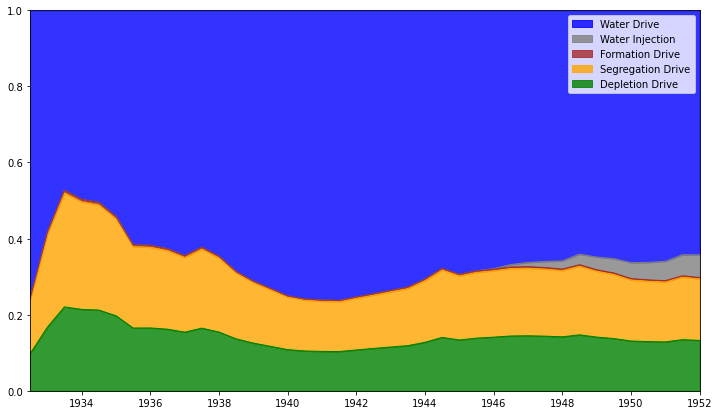

In [ ]:
def energy_plot(t, Idd, Isd, Ifd, Iwi):
  t = (df['date'].values)[1:]
  Idd_curve = Idd[1:]
  Isd_curve = Idd[1:] + Isd[1:]
  Ifd_curve = Idd[1:] + Isd[1:] + Ifd[1:]
  Iwi_curve = Idd[1:] + Isd[1:] + Ifd[1:] + Iwi[1:]
  
  plt.figure(figsize=(12,7))

  plt.plot(t, Idd_curve, color='green', linewidth=1)
  plt.plot(t, Isd_curve, color='orange', linewidth=1)
  plt.plot(t, Iwi_curve, color='grey', linewidth=1)
  plt.plot(t, Ifd_curve, color='brown', linewidth=1)

  y0 = np.full(len(t), 0)
  y1 = np.full(len(t), 1)

  wd = plt.fill_between(t, y1, Iwi_curve, color='blue', 
                        alpha=.8) 
  wi = plt.fill_between(t, Iwi_curve, Ifd_curve, color='grey', 
                        alpha=.8) 
  fd = plt.fill_between(t, Ifd_curve, Isd_curve, color='brown', 
                        alpha=.8) 
  sd = plt.fill_between(t, Isd_curve, Idd_curve, color='orange', 
                        alpha=.8) 
  dd = plt.fill_between(t, Idd_curve, y0, color='green', 
                        alpha=.8) 
  plt.legend(handles=[wd, wi, fd, sd, dd], 
             labels=['Water Drive', 'Water Injection', 'Formation Drive',
                     'Segregation Drive', 'Depletion Drive'])

  plt.xlim(min(t), max(t))
  plt.ylim(0,1) 
  plt.xlabel('Year')
  plt.ylabel('Index') 

  plt.show()

energy_plot(t, Idd, Isd, Ifd, Iwi)

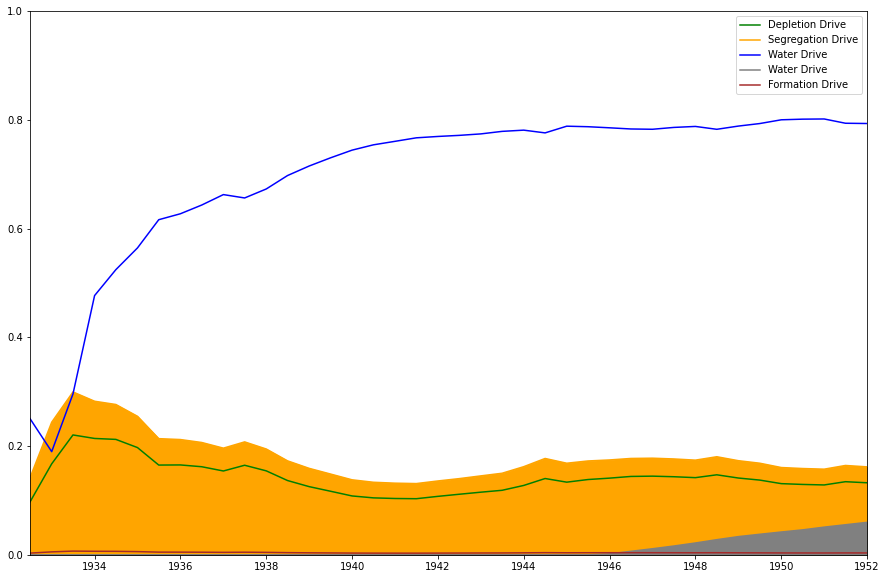

In [ ]:
plt.figure(figsize=(15,10))

ymin = np.full(len(t[1:]), 0)

plt.plot(t[1:], Idd[1:], color='green', label='Depletion Drive')
plt.plot(t[1:], Isd[1:], color='orange', label='Segregation Drive')
plt.plot(t[1:], Iwd[1:], color='blue', label='Water Drive')
plt.plot(t[1:], Iwi[1:], color='grey', label='Water Drive')
plt.plot(t[1:], Ifd[1:], color='brown', label='Formation Drive')
plt.fill_between(t[1:], Idd[1:], ymin, color='green', 
                 alpha=1) 
plt.fill_between(t[1:], Isd[1:], ymin, color='orange', 
                 alpha=1) 
# plt.fill_between(t[1:], Iwd[1:], ymin, color='blue', 
#                  alpha=1) 
plt.fill_between(t[1:], Iwi[1:], ymin, color='grey', 
                 alpha=1) 
plt.xlim(t[1], max(t))
plt.ylim(0,1)

plt.legend()
plt.show()

## *** 

In [ ]:
for j in range(1,len(p)):
  print(p[j-1])

2180
2164
2115
2065
2015
1965
1915
1865
1815
1765
1715
1665


In [ ]:
for j in range(len(p)-1):
  print(p[j+1])

2164
2115
2065
2015
1965
1915
1865
1815
1765
1715
1665
1615
